In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

Goals:
- Use encoding methods studied previously
- Build a more complicated scikit-learn pipeline
- Discover feature engineering

# 1. Dataset quick outlook and preformating

## 1.1 Data

In [2]:
# load dataset titanic
path_data = '/home/lemasle/PROJECTS/data/Kaggle_Titanic-Machine_Learning_from_Disaster/'
# Some columns include nans, we import them as strings
input_train = pd.read_csv(path_data+'train.csv', na_values=['NaN'])
input_test = pd.read_csv(path_data+'test.csv', na_values=['NaN'])

In [3]:
input_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId
Survived: Survival 	 (0 = No, 1 = Yes)\
Pclass:   Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)\
Name:     Name\
Sex:      Sex\
Age:      Age in years\
SibSp:    Number of siblings/spouses aboard the Titanic\
Parch:    Number of parents / children aboard the Titanic\
Ticket:   Ticket number\
Fare:     Passenger fare\
Cabin:    Cabin number\
Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## 1.2 Preformatting

### 1.2.1 Removing columns

"PassengerId" is an internal label of the dataset - it can be discarded.\
"Ticket"  is simply a label, with no influence on the survival. The ticket label may refer to the location/price of the cabin, but this information is included in te "Fare" and "Cabin" columns: So we discard "Ticket" as well. However, it is possible to do some feature engineering here.\
"Name" should not have any influence on the survival, we decide to discard it.

In [4]:
def remove_columns(df, list_of_columns):

    # list_of_columns = ["PassengerId", "Name", "Ticket"]
    df.drop(columns=list_of_columns, inplace=True)

    return df

### 1.2.2 Feature engineering

Note however that it contains some information, sometimes redundant (Mr, Mrs), sometimes not (Dr, Rev). We will use this information to create a new feature: 'Title'.\
The structure of strings in the first columns is as follows:

[Lastname]  [comma]  [Title]  [dot]  [List of firstnames]

So we can split each string accordingly and select the item between "comma" and "dot" as the title. 

In [5]:
def get_title_feature(df):
    
    # split info in df['Name'] and get title 
    title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
    # Convert the list in a series and include it in the original dataframe
    df["Title"] = pd.Series(title)
    df.drop(columns=['Name'], inplace=True)
    
    return df

### 1.2.3 Missing values

In [6]:
input_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### 1.2.3.1 Missing data: some more feature engineering

"Cabin" contains a lot (almost 700) of missing values.\
We could remove the entire column, but we would then loose some (potentially useful) information.\
Instead, we can transform this columns to a boolean indicating whether cabin information is available (1) or not (0).\
This is not much information, but better than nothing.

In [7]:
def cabin_to_boolean(df):
    
    df['Cabin'] = np.where(df['Cabin'].isna(), 0.0, 1.0)
    
    return df

It is possible to transform a function so that it can be easily integrated into a pipeline. This is achieved via the FunctionTransformer command.

In [8]:
from sklearn.preprocessing import FunctionTransformer
CabinTransformer = FunctionTransformer(cabin_to_boolean)

In [9]:
test_cabin = CabinTransformer.transform(input_train)
test_cabin

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0.0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0.0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1.0,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,0.0,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,1.0,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,0.0,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,1.0,C


#### 1.2.3.2 Missing data: categorical data

"Embarked" contains only two missing values.\
We could always consider removing the two corresponding rows, which would have little impact if they correspond to well-represented passenger profiles, but a higher impact if they happen to be rare occurences of a specific profile.\
Instead, we can impute them the most frequent embarkment spot, the hypotheses being that i) we still have a good chance that this arbitrary assignment is correct ii) the model will still perform better with two potentially wrong embarkment spots than with two full passenger profiles deleted.

In [10]:
def fillna_with_most_frequent(df, list_of_cols):

    for col in list_of_cols:
        # Get the mode of a set of values, that is the value that appears most often
        col_mode = df[col].mode()
        # fill NaNs with the most frequent value
        df[col].fillna(col_mode.values[0], inplace=True)

    return df

Note: In the train sample, only "embarked" contains missing data. It could happen that in the test sample, also other categorical columns ('Sex', 'Pclass') contain missing values. We can use the same strategy (most frequent) to replace missing values for those columns.

Instead of using pandas functions, we will take advantage of scikit-learn SimpleImputer:
1. they can be applied to several columns
2. they can be integrated in a scikit-learn pipeline

In [11]:
# Get data for testing the method
test_freq_imputer = input_train[['Sex', 'Pclass', 'Embarked']]
test_freq_imputer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sex       891 non-null    object
 1   Pclass    891 non-null    int64 
 2   Embarked  889 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


In [12]:
#import and define the imputer
from sklearn.impute import SimpleImputer
mostfrequent_imputer = SimpleImputer(strategy='most_frequent')

In [13]:
# fit the imputer on the input data
mostfrequent_imputer.fit(test_freq_imputer)
# impute all missing values in the data.
X_frq = mostfrequent_imputer.transform(test_freq_imputer)
# inspect the results, check that missing values have been replaced
df_frq = pd.DataFrame(X_frq, columns=test_freq_imputer.columns, index=test_freq_imputer.index)
df_frq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sex       891 non-null    object
 1   Pclass    891 non-null    object
 2   Embarked  891 non-null    object
dtypes: object(3)
memory usage: 21.0+ KB


#### 1.2.3.3 Missing data: numerical data

"Age" contains a good number (a bit more than 150) of missing values (NaNs).\
However 2/3rd of the rows contain potentially useful data (very young/very old people probably have a lower chance of survival), so it would be painful to remove the entire column.

One possibility is to fill missing values with the mean or median age (the median is less sensitive to large outliers than the mean).

In [14]:
def fillna_with_median(df, list_of_cols):

    for col in list_of_cols:
        # get the median age
        col_median = df[col].median()
        # fill NaNs with the median value
        df[col].fillna(col_median.values[0], inplace=True)
    
    return df

Note: One should always be careful while introducing operations like mean() or median() in the early stages of a pipeline, as it could induce data leakage: rows in the train (respectively test) data would get clues about the ages in the test (respectively train) data. **In this specific example**, the train and test dataset are already split so we are not exposed to this risk.

Note: In the train sample, only "age" contains missing data. It could happen that in the test sample, also other numerical columns ('SibSp', 'Parch', 'Fare') contain missing values. We can use the same strategy (median value) to replace missing values for those columns.

Instead of using pandas functions, we will take advantage of scikit-learn SimpleImputer:
1. they can be applied to several columns
2. they can be integrated in a scikit-learn pipeline

In [15]:
# Get data for testing the method
test_median_imputer = input_train[['Age', 'SibSp', 'Parch', 'Fare']]
test_median_imputer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     714 non-null    float64
 1   SibSp   891 non-null    int64  
 2   Parch   891 non-null    int64  
 3   Fare    891 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 28.0 KB


In [16]:
#import and define the imputer
from sklearn.impute import SimpleImputer
median_imputer = SimpleImputer(strategy='median')

In [17]:
# fit the imputer on the input data
median_imputer.fit(test_median_imputer)
# impute all missing values in the data.
X_med = median_imputer.transform(test_median_imputer)
# inspect the results, check that missing values have been replaced
df_med = pd.DataFrame(X_med, columns=test_median_imputer.columns, index=test_median_imputer.index)
df_med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     891 non-null    float64
 1   SibSp   891 non-null    float64
 2   Parch   891 non-null    float64
 3   Fare    891 non-null    float64
dtypes: float64(4)
memory usage: 28.0 KB


## 1.3 Encoding

### 1.3.1 Ordinal encoding

We will use ordinal encoding to encode the 'Sex' column, from 'Male'/'Female' to (0,1)

In [18]:
#import and define the encoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
# fit and apply the encoder to the data
sex_oe = ordinal_encoder.fit_transform(df_frq[['Sex']]) # Note the double [[ ]] as input data needs to be 2D
sex_oe[:5]

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.]])

We will use ordinal encoding to encode the 'Pclass' column, from (1,2,3) to (0,1,2).\
We want to preserve the order as 2nd class cabins lie in between 1st class cabins and 3rd class cabins.

In [19]:
#import and define the encoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
# fit and apply the encoder to the data
pclass_oe = ordinal_encoder.fit_transform(df_frq[['Pclass']]) # Note the double [[ ]] as input data needs to be 2D
pclass_oe[:5]

array([[2.],
       [0.],
       [2.],
       [0.],
       [2.]])

### 1.3.2 One-Hot-Encoding

Although the inaugural trip of the Titanic started in Southampton, then went to Cherbourg, and finally to Queenstown, there is no specific order between the cities, expecially regarding the chances for survival.\
Thus One-Hot-Encoding is the best method for the 'Embarked' column.

In [20]:
#import and define the encoder
from sklearn.preprocessing import OneHotEncoder
embarked_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# fit and apply the encoder to the data
embarked_ohe = embarked_encoder.fit_transform(df_frq[['Embarked']]) # Note the double [[ ]] as input data needs to be 2D
embarked_ohe

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

IMPORTANT NOTE: handle_unknown=’ignore’ is specified to prevent errors with unseen categories in the testing set.\
(categories present in the testing set but not present in the training set).

### 1.3.3 More feature engineering

#### 1.3.3.1: Traveling alone or with families

In [21]:
input_train['SibSp'].value_counts()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [22]:
input_train['Parch'].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

Both "SibSp" (number of siblings/spouses aboard) and "Parch" (number of parents/children aboard) contain 7 unique categories.\
However, data are concentrated in 2+3 highly populated categories while some others contain only a handul objects. There is therefore a risk of overfitting.\
More importantly, encoding via one-hot-encoding would replace two columns with 14 new ones, and such a strong increase of dimensionality is probably not a good thing.\
For the sake of the exercise, we will also perform some feature engineering here, simply asking whether people travel alone or not.

In [23]:
def Is_Alone(df):

    df['Is_Alone'] = np.where( (df['SibSp'] + df['Parch'])>0, 0.0, 1.0)
    df.drop(columns=['SibSp', 'Parch'], inplace=True)
    
    return df

In [24]:
Is_Alone(input_train)['Is_Alone'].value_counts()

Is_Alone
1.0    537
0.0    354
Name: count, dtype: int64

In [25]:
# It is not useful to import FunctionTransformer again
# I show it again for clarity 
from sklearn.preprocessing import FunctionTransformer
FamilyTransformer = FunctionTransformer(Is_Alone)

#### 1.3.3.2: Revisiting and encoding 'Title'

In [26]:
test_title = pd.DataFrame(get_title_feature(input_train), columns=['Title'])
test_title['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

A number of those are duplicates due to convention (Ms=Mrs) or language (Mme=Mrs, Don=Sir). We will simplify the 'Title' column by mapping a dictionnary before encoding it.

In [27]:
input_train.loc[input_train.Title=='Master']['Age'].unique()

array([ 2.  ,  7.  , 11.  ,  4.  ,   nan,  0.83, 12.  ,  1.  ,  9.  ,
        3.  ,  0.92,  8.  ,  6.  ,  0.67,  0.42, 10.  ])

If we inspect ages of passengers with title 'Master', we discover that all of them are kids.\
In passing, the presence of NaNs indicates that we could do a more clever job imputing ages than simply taking the median (whatever value between 0 and 12 would be better than the median).

In [28]:
Title_dict = {'Mr': 'Mr',
              'Miss' : 'Miss',
              'Mrs' : 'Mrs',
              'Master' : 'Master',
              'Dr' : 'Other',
              'Rev' : 'Other',
              'Mlle' : 'Miss',
              'Major' : 'Other',
              'Col' : 'Other',
              'the Countess' : 'Noble',
              'Capt' : 'Other',
              'Ms' : 'Mrs',
              'Sir' : 'Noble',
              'Lady' : 'Noble',
              'Mme' : 'Mrs',
              'Don' : 'Noble',
              'Jonkheer' : 'Noble',
              }

In [29]:
test_title['Title'] = test_title['Title'].map(Title_dict)
test_title['Title'].value_counts()

Title
Mr        517
Miss      184
Mrs       127
Master     40
Other      18
Noble       5
Name: count, dtype: int64

A new function to create the 'Title' combines the original function with the above mapping 

In [30]:
def TitleFeature(df, Title_dict):
    
    # Split info in df['Name'] and get title 
    title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
    # Convert the list in a series and include it in the original dataframe
    df["Title"] = pd.Series(title)
    # Map the new feature using the dictionnary
    df['Title'] = df['Title'].map(Title_dict)
    # Remove the previous 'Name' column
    df.drop(columns=['Name'], inplace=True)

    return df    

In [31]:
# It is not useful to import FunctionTransformer again
# I show it again for clarity 
from sklearn.preprocessing import FunctionTransformer
TitleTransformer = FunctionTransformer(TitleFeature, kw_args={'Title_dict':Title_dict} )

Note the syntax **kw_args={'Name':  variable}** used to **pass an argument** to the FunctionTransformer.

In [32]:
#import and define the encoder
from sklearn.preprocessing import OneHotEncoder
titles_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# fit and apply the encoder to the data
titles_ohe = titles_encoder.fit_transform(test_title[['Title']]) # Note the double [[ ]] as input data needs to be 2D
print(np.shape(titles_ohe))
titles_ohe

(891, 6)


array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

## 1.4 Summary

- Missing data:
 1. Replace missing values with the 'most frequent' strategy for the columns 'Sex', 'Pclass', 'Embarked'.
 2. Replace missing values with the 'median' strategy for the columns 'Age', 'SibSp', 'Parch', 'Fare'.
- Feature engineering:
 1. Create the new column 'Title', the column 'Name' can be removed.
 2. Create the new column 'Is_Alone, the columns 'SibSp', 'Parch' can be removed.
 3. Create the new column 'Cabin', the column 'Cabin' is replaced. 
- Encoding:
 1. Ordinal encoding for the columns 'Sex', 'Pclass'.
 2. One-hot-encoding for the columns 'Embarked', 'Title'.
 3. Encoding of the column 'Cabin' (done by design, no specific action required).
- NEW: we would like to StandardScale() the columns 'Age', 'Fare'
  
- Remove unnecessary columns:
 1. Not considered at all: 'PassengerId', 'Ticket'.
 2. Not useful anymore after feature engineering: 'Name', 'SibSp', 'Parch'.
 3. Train and test data are already split, the column 'Survived' is kept for now.\
    It will be used to form y_train (resp. y_test).\
    We should not forget to remove it from X_train (resp. X_test).

Writing the summary above helps understanding the workflow.\
For instance, operations are not necessarily processed in the order originally considered.\
Also, it appears that the columns not considered can be removed either at the very beginning (or very end) of the process, and the columns superseded by feature engineering can be removed within the feature engineering stage itself.

# 2. Pipeline building: columns transformations

In order to group all the individual steps listed above, we will have to:
 1. Include each of them inside a Pipeline instance
 2. Group these pipeline instances using ColumnTransformer 

## 2.1 Individual steps

In [33]:
from sklearn.pipeline import Pipeline

In [34]:
# num_missing applies to 'Age', 'Fare', 'SibSp', 'Parch'.
# Missing values are median-imputed.
num_missing = Pipeline(steps=[
    ('impute',  SimpleImputer(strategy='median')),
    ]).set_output(transform="pandas")

num_cols = ['Age', 'Fare', 'SibSp', 'Parch']    

In [35]:
# cat_missing applies to 'Sex', 'Pclass', 'Embarked'.
# Missing values are most_frequent-imputed
cat_missing = Pipeline(steps=[
    ('impute',  SimpleImputer(strategy='most_frequent')),
    ]).set_output(transform="pandas")

cat_cols = ['Sex', 'Pclass', 'Embarked']    

In [36]:
# title_feat_eng applies to 'Name'
# this column is not used anymore    
title_feat_eng= Pipeline(steps=[
    ('Title', TitleTransformer)
    ]).set_output(transform="pandas")

title_cols = ['Name']

In [37]:
# family_feat_eng applies to 'SibSp', 'Parch'
# these columns are not used anymore    
family_feat_eng= Pipeline(steps=[
    ('HasFamily', FamilyTransformer)
    ]).set_output(transform="pandas")

family_cols = ['SibSp', 'Parch']

In [38]:
# cabin_feat_eng applies to 'Cabin'
# the column is replaced
cabin_feat_eng = Pipeline(steps=[
    ('HasCabin', CabinTransformer)
    ]).set_output(transform="pandas")

cabin_cols = ['Cabin']

In [39]:
# o_encoder applies to 'Sex', 'Pclass'.
o_encoder = Pipeline(steps=[
    ('Ordinal Encoder', OrdinalEncoder())
    ]).set_output(transform="pandas")
     
o_cols = ['Sex', 'Pclass']

In [40]:
# ohe_encoder applies to 'Embarked', 'Title'.
ohe_encoder = Pipeline(steps=[
    ('One-Hot Encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]).set_output(transform="pandas")

ohe_cols = ['Embarked', 'Title']

In [41]:
# We want to apply standard scaling to  'Age', 'Fare'.
from sklearn.preprocessing import StandardScaler
scaler = Pipeline(steps=[
    ('standard_scaler',StandardScaler())
    ]).set_output(transform="pandas")

sc_cols = ['Age', 'Fare']

In [42]:
# We want to remove the columns 'PassengerId', 'Ticket', ('Survived')

rem_cols = ['PassengerId', 'Ticket']

# Transform function to transformer
# It is not useful to import FunctionTransformer again
# I show it again for clarity 
from sklearn.preprocessing import FunctionTransformer
RemoveTransformer = FunctionTransformer(remove_columns, kw_args={'list_of_columns': rem_cols} )

# Create pipeline instance
remove_colums= Pipeline(steps=[
    ('Remove_columns', RemoveTransformer)
    ]).set_output(transform="pandas")

Note the use of **.set_output(transform="pandas")** to ensure that the outcome of the individual step will be a dataframe, not a numpy array.

## 2.2 Using ColumnTransfomer to concatenate individual steps

The syntax of a ColumnTransformer is as follows:

ColumnTransformer(transformers=[(‘step name’, transform function,cols), …])

In [43]:
from sklearn.compose import ColumnTransformer

missing = ColumnTransformer(transformers=[
    ('Numerical_missing_numbers', num_missing, num_cols),
    ('Categorical_missing_numbers', cat_missing, cat_cols)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough',
    n_jobs=-1)
  
features = ColumnTransformer(transformers=[
    ('Title_feature_engineering', title_feat_eng, title_cols),
    ('HasFamily_feature_engineering', family_feat_eng, family_cols),
    ('Cabin_feature_engineering', cabin_feat_eng, cabin_cols)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough',
    n_jobs=-1)

encoding = ColumnTransformer(transformers=[
    ('Ordinal_encoding', o_encoder, o_cols),
    ('One-Hot-Encoding', ohe_encoder, ohe_cols)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough',
    n_jobs=-1)

final = ColumnTransformer(transformers=[
    ('Standard_scaling', scaler, sc_cols),
    ('Remove_columns', remove_colums, rem_cols)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough',
    n_jobs=-1)

If **remainder='passthrough'** not set, the default value ('drop') is used, and the columns that have not been transformed are dropped.\
If **verbose_feature_names_out** not set to False, the name of the transformer is appended as prefix to the dataframe column names, which will cause an error at the next stage (the column names have been modified).

In [44]:
first_pipeline = Pipeline(steps=[
    ('missing_data', missing),
    ('feature_creation', features),
    ('encoding', encoding),
    ('finalization', final)
]).set_output(transform="pandas")

In [45]:
from sklearn import set_config

set_config(display='diagram')
display(first_pipeline)

Pipeline(steps=[('missing_data',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('Numerical_missing_numbers',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('Categorical_missing_numbers',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Sex', 'Pclass',
                                                   'Embarked'])]...
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('Standard_scaling',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('Remove_columns',
                                                  Pipeline(steps=[('Remove_columns',
                                                                   FunctionTransformer(func=<function remove_columns at 0x7fad39a0ec00>,
                                                                                       kw_args={'list_of_columns': ['PassengerId',
                                                                                                                    'Ticket']}))]),
                                                  ['PassengerId', 'Ticket'])],
                                   verbose_feature_names_out=False))])

## 2.3 Running the data preparation stage of the pipeline

For the purpose of this lecture, we have run a number of tests which have modified the input dataframe.\
To start with 'fresh' data, we import the data again.

In [46]:
del input_train, input_test
# Some columns include nans, we import them as strings
input_train = pd.read_csv(path_data+'train.csv', na_values=['NaN'])
input_test = pd.read_csv(path_data+'test.csv', na_values=['NaN'])

In [47]:
X_train = input_train.drop(columns=['Survived'])
y_train = input_train['Survived']

In [48]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [49]:
input_transformed = first_pipeline.fit_transform(X_train)

In [50]:
input_transformed 

,Age,Fare,Sex,Pclass,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Noble,Title_Other,Is_Alone,Cabin
0,-0.565736,-0.502445,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.663861,0.786845,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.258337,-0.488854,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.433312,0.420730,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.433312,-0.486337,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.181487,-0.386671,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
887,-0.796286,-0.044381,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
888,-0.104637,-0.176263,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
889,-0.258337,-0.044381,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


## 2.4 Including a model in the pipeline

We have plenty of models to select from. Here we pick one (for instance, RandomForest), the correct process would be to test several of them and pick the one which performs best.

In [51]:
# Initiate a model with random hyperparameters
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=200,
                                  max_depth=5,
                                  min_samples_split=5,
                                  n_jobs=-1,
                                  random_state=0)

In [52]:
# Integrate the model in the previous pipeline
full_pipeline = Pipeline(steps=[
    ('missing_data', missing),
    ('feature_creation', features),
    ('encoding', encoding),
    ('finalization', final),
    ('model', model_rf)
]).set_output(transform="pandas")

#display(full_pipeline)

To evaluate the model, we must have test data at our disposal.\
The test data provided actually contains only X_test, y_test (that would be the column input_test['Survived']) is not given since it is the purpose of the kaggle competition.\
We will produce our own train/test data from the original input_train dataframe.\
Note: By doing this, we definitely introduce some data leakage since we used most_frequent and median to replace missing values.

In [53]:
# prepare the input data
X = input_train.drop(columns=['Survived'])
y = input_train['Survived']

# delete the currant instances of X_train, y_train
del X_train, y_train

# split into train/test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [54]:
# Pipeline_fit is the command to process data through the pipeline, including model fitting.
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('missing_data',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('Numerical_missing_numbers',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('Categorical_missing_numbers',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Sex', 'Pclass',
                                                   'Embarked'])]...
                                                  ['Age', 'Fare']),
                                                 ('Remove_columns',
                                                  Pipeline(steps=[('Remove_columns',
                                                                   FunctionTransformer(func=<function remove_columns at 0x7fad39a0ec00>,
                                                                                       kw_args={'list_of_columns': ['PassengerId',
                                                                                                                    'Ticket']}))]),
                                                  ['PassengerId', 'Ticket'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 RandomForestClassifier(max_depth=5, min_samples_split=5,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=0))])

In [55]:
# Pipeline.predict is the command to predict the outcome on unseen data thanks to the model trained just above.
y_pred = full_pipeline.predict(X_test)

In [56]:
# Pipeline.score computes the 'score' of the pipeline (preprocessing + model).
# Here the score is the accuracy of the RandomForest Classification
score = full_pipeline.score(X_test, y_test)
print('\nModel score:', score)


Model score: 0.776536312849162


Conclusion: with the current hyperparameters, roughly 80%  of our predictions are correct.\
However, the (randomly) selected values for the hyperparameters are not necessarily the best, we need to tune the hyperparameers to achieve the best possible predictions.

# 3. Hyperparameters tuning

## 3.1 Hyperparameters tuning using  RandomizedSearchCV

We do not know a priori what are the appropriate values for the hyperparameters, and they could cover quite a large range.\
So we use RandomizedSearchCV to perform a quick search for the hyperparameters values.\
It will always be possible to refine the search later for an even finer tuning of the hyperparameters.

In [57]:
from sklearn.model_selection import RandomizedSearchCV

We use distributions from scipy to sample the hyperparameters.\

In [58]:
from scipy.stats import randint

randint(low=low, high=high) provides a uniform distribution of integers in the range [low, low + high].

In [59]:
hyper_params = {'model__n_estimators' : randint(low=5, high=2000),
                'model__max_depth' : randint(low=1, high=10),
                'model__min_samples_split' : randint(low=2, high=10),}

Note: **model__** specifies which step of the pipeline the hyperparameter is associated with.

In [60]:
rs = RandomizedSearchCV(full_pipeline, hyper_params, cv=3, scoring='accuracy', n_iter=20)
# n_iter=20 indicates that the RandomizedSearch will iterate 20 times before stopping the search for the best parameters
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('missing_data',
                                              ColumnTransformer(n_jobs=-1,
                                                                remainder='passthrough',
                                                                transformers=[('Numerical_missing_numbers',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['Age',
                                                                                'Fare',
                                                                                'SibSp',
                                                                                'Parch']),
                                                                              ('Categorical_missing_numbers',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent'...
                   n_iter=20,
                   param_distributions={'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fad3836a660>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fad33eccda0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fad383686b0>},
                   scoring='accuracy')

In [61]:
print("Best Score of train set: "+str(rs.best_score_))
print("Best parameter set: "+str(rs.best_params_))
print("Test Score: "+str(rs.score(X_test,y_test)))

Best Score of train set: 0.8244453899703341
Best parameter set: {'model__max_depth': 9, 'model__min_samples_split': 7, 'model__n_estimators': 1622}
Test Score: 0.7988826815642458


In [62]:
pd.DataFrame(rs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.891183,0.111813,0.211779,0.055404,3,9,1096,"{'model__max_depth': 3, 'model__min_samples_sp...",0.789916,0.843882,0.780591,0.804796,0.027899,15
1,0.462410,0.033984,0.111774,0.017908,3,3,193,"{'model__max_depth': 3, 'model__min_samples_sp...",0.794118,0.839662,0.801688,0.811823,0.019927,13
2,0.716760,0.051556,0.126227,0.028127,3,3,323,"{'model__max_depth': 3, 'model__min_samples_sp...",0.794118,0.839662,0.784810,0.806197,0.023967,14
3,2.898027,0.134780,0.276281,0.038787,4,4,1721,"{'model__max_depth': 4, 'model__min_samples_sp...",0.789916,0.843882,0.822785,0.818861,0.022206,7
4,2.497015,0.187755,0.280210,0.059910,5,5,1549,"{'model__max_depth': 5, 'model__min_samples_sp...",0.798319,0.839662,0.822785,0.820256,0.016973,3
5,2.180607,0.044036,0.238116,0.015746,9,7,1622,"{'model__max_depth': 9, 'model__min_samples_sp...",0.819328,0.835443,0.818565,0.824445,0.007783,1
6,2.305865,0.023449,0.258160,0.029561,2,9,1825,"{'model__max_depth': 2, 'model__min_samples_sp...",0.789916,0.801688,0.780591,0.790731,0.008632,17
7,1.866291,0.062897,0.206663,0.002564,8,9,1456,"{'model__max_depth': 8, 'model__min_samples_sp...",0.810924,0.831224,0.818565,0.820238,0.008371,5
8,2.290251,0.082671,0.244071,0.009477,1,9,1787,"{'model__max_depth': 1, 'model__min_samples_sp...",0.726891,0.734177,0.746835,0.735968,0.008240,19
9,0.910559,0.017341,0.146609,0.015409,1,3,690,"{'model__max_depth': 1, 'model__min_samples_sp...",0.726891,0.721519,0.746835,0.731748,0.010891,20


The test data contains 110 deaths and 69 survivals. 

In [63]:
y_test.value_counts()

Survived
0    110
1     69
Name: count, dtype: int64

We can inspect the outcome of the modelling using several tools:

In [64]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       110
           1       0.76      0.61      0.68        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.75       179
weighted avg       0.78      0.78      0.77       179



In [66]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[97 13]
 [27 42]]


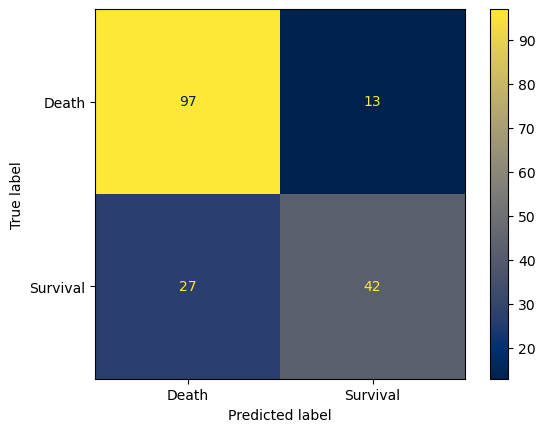

In [67]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Death', 'Survival'])
cm_display.plot(cmap='cividis')

Out of 110 deaths, the model predicts 97 of them correctly.\
Out of  69 survivals, the model predicts 42 of them correctly.\
So a grand total of 77% correct predictions.\
27 predicted deaths were actually survivals, while 13 predicted survivals were actually deaths.